In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# Sims with gamma

In [5]:
def EyalSirer(a, g):
    num = a * ((1-a)**2) * (4*a + g*(1-2*a)) - a**3
    den = 1 - a * (1 + (2-a) * a)
    return num / den

def REWARD2(alpha, beta, gamma):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [3]:
EyalSirer(0.25,1/2), EyalSirer(0.3,0.25), EyalSirer(1/3,0)

(0.25, 0.29999999999999993, 0.33333333333333337)

In [7]:
alphas = np.arange(0.01, 0.5, 0.001)
gammas = [0, 0.5, 1]

ES_THEO       = []
REWARD2_THEO  = []
for g in gammas:
    ES_THEO.append([EyalSirer(a, g) for a in alphas])
    REWARD2_THEO.append([REWARD2(a, 100, g) for a in alphas])
ES_THEO    = np.array(ES_THEO)
REWARD2_THEO = np.array(REWARD2_THEO)
ES_THEO.shape, REWARD2_THEO.shape

((3, 490), (3, 490))

In [8]:
def simES(alpha, gamma, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    for _ in range(n):
        attBlock  = np.random.binomial(1, alpha)

        if state == [0,0]:
            if attBlock:
                state = [1,0]
            else:
                honestBlcs += 1
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
            else:
                sample = np.random.uniform()
                if sample < alpha:
                    attackBlcs += 2
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                else: 
                    honestBlcs += 2
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            state = [0,0]

    totalBlcs = honestBlcs + attackBlcs
    return attackBlcs/totalBlcs

In [9]:
simAlphas = np.arange(0.025, 0.5, 0.025)
ES_SIM = []
for g in gammas:
    temp = []
    for a in simAlphas:
        print('alpha={:0.3f}, gamma={:0.3f}'.format(a,g), end='\r')
        temp2 = []
        for j in range(10):
            temp2.append(simES(a, g, n=int(1e5)))
        temp.append(np.mean(temp2))
    ES_SIM.append(temp)
ES_SIM = np.array(ES_SIM)
ES_SIM.shape

(3, 19)

In [12]:
def simCKWN(alpha, gamma, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                state = [1,0]
                lastAttBlc = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackRews += (remRews + execRews)
            else:
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [11]:
simAlphas = np.arange(0.025, 0.5, 0.025)
CKWN_SIM = []
for g in gammas:
    temp = []
    for a in simAlphas:
        print('alpha={:0.3f}, gamma={:0.3f}'.format(a,g), end='\r')
        temp2 = []
        for j in range(10):
            temp2.append(simCKWN(a, g, n=int(1e5)))
        temp.append(np.mean(temp2))
    CKWN_SIM.append(temp)
CKWN_SIM = np.array(CKWN_SIM)
CKWN_SIM.shape

(3, 19)

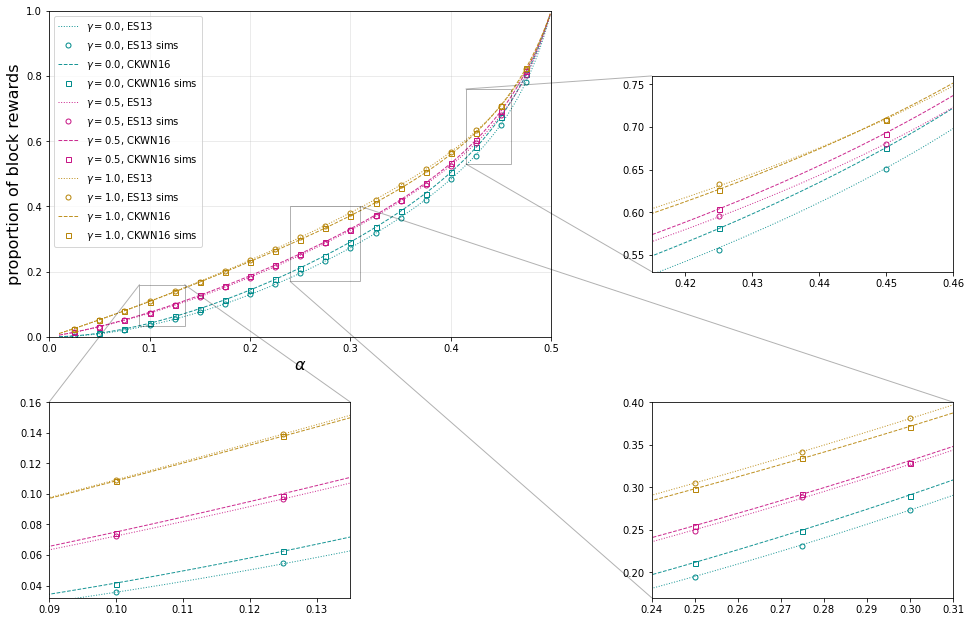

In [13]:
f, ax = plt.subplots(figsize=(9,6))

axins0 = ax.inset_axes([0., -0.8, 0.6, 0.6], xlim=(0.09, 0.135), ylim=(0.032, .16))
axins1 = ax.inset_axes([1.2, -0.8, 0.6, 0.6], xlim=(0.24, 0.31), ylim=(0.17, 0.4))
axins2 = ax.inset_axes([1.2, 0.2, 0.6, 0.6], xlim=(0.415, 0.46), ylim=(0.53, 0.76))
ax.indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)

colors = ['darkcyan', 'mediumvioletred', 'darkgoldenrod'] 
for a in [ax, axins0, axins1, axins2]:
    for i, g in enumerate(gammas):
        a.plot(alphas, ES_THEO[i], label=r'$\gamma=${:0.1f}, ES13'.format(g), 
               linestyle='dotted', color=colors[i], alpha=0.9, linewidth=1)
        a.plot(simAlphas, ES_SIM[i], linestyle='none', color=colors[i], marker='o', fillstyle='none',
                markersize=5, label=r'$\gamma=${:0.1f}, ES13 sims'.format(g))

        a.plot(alphas, REWARD2_THEO[i], label=r'$\gamma=${:0.1f}, CKWN16'.format(g),
               linestyle='--', color=colors[i], alpha=0.9, linewidth=1)
        a.plot(simAlphas, CKWN_SIM[i], linestyle='none', color=colors[i], marker='s', fillstyle='none',
                markersize=5, label=r'$\gamma=${:0.1f}, CKWN16 sims'.format(g))

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'proportion of block rewards', size=16)
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)
ax.legend()
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')

plt.show()

# Optimal beta sims

In [14]:
def calcHGamma(a, b, gamma):
    exp1 = (1-a) / (a * (1 - np.exp(-b)))
    exp2 = np.power(1-a, 2) * (2-gamma)
    exp3 = a * (1-a)
    return (exp1 + exp2 + exp3)

def calcAGamma(a, b, gamma):
    exp1 = np.exp(-b) / (a * (1-np.exp(-b)))
    exp2 = 2 - a + ((2-a)/(1-a))
    exp3 = np.power(1-a, 2) * gamma / a
    exp4 = np.power(a,2) / ((1-2*a)*(1-a))
    return a * (exp1 + exp2 + exp3 + exp4)

def calcAOverAHGamma(a, b, gamma):
    return calcAGamma(a,b,gamma) / (calcAGamma(a,b,gamma) + calcHGamma(a,b,gamma))

def calcTotalRewardGamma(a, b, gamma, scale=1):
    return (scale*REWARD2(alpha=a, beta=b, gamma=gamma) + calcAOverAHGamma(a=a, b=b, gamma=gamma)) / (scale + 1)

In [15]:
# CKWN optimal betas (exec rewards only)
alphas = np.arange(0.01, 0.5, 0.001)
betas  = np.arange(0.01, 5.01, 0.01)
opt_betas_exec = []
for alpha in tqdm(alphas):
    rews = [REWARD2(alpha=alpha, beta=b, gamma=0.) for b in betas]
    opt_betas_exec.append(betas[np.argmax(rews)])
opt_betas_exec = np.asarray(opt_betas_exec)

100%|██████████| 490/490 [00:03<00:00, 134.65it/s]


In [16]:
# our optimal betas (exec & block rewards only)
alphas = np.arange(0.01, 0.5, 0.001)
betas  = np.arange(0.01, 10.01, 0.01)
opt_betas_both = []
for alpha in tqdm(alphas):
    rews = [calcTotalRewardGamma(a=alpha, b=b, gamma=0., scale=1.) for b in betas]
    opt_betas_both.append(betas[np.argmax(rews)])
opt_betas_both = np.asarray(opt_betas_both)

100%|██████████| 490/490 [00:16<00:00, 30.39it/s]


In [17]:
CKWN_theo_opt_beta = []
OURS_theo_opt_beta = []
ES_tho_beta_infty  = []
for i in tqdm(range(len(alphas))):
    a, optb_exec, optb_both = alphas[i], opt_betas_exec[i], opt_betas_both[i]
    CKWN_theo_opt_beta.append(calcTotalRewardGamma(a=a, b=optb_exec, gamma=0., scale=1.))
    OURS_theo_opt_beta.append(calcTotalRewardGamma(a=a, b=optb_both, gamma=0., scale=1.))
    ES_tho_beta_infty.append(calcTotalRewardGamma(a=a, b=100., gamma=0., scale=1.))
CKWN_theo_opt_beta = np.array(CKWN_theo_opt_beta)
OURS_theo_opt_beta = np.array(OURS_theo_opt_beta)
ES_tho_beta_infty  = np.array(ES_tho_beta_infty)
CKWN_theo_opt_beta.shape, OURS_theo_opt_beta.shape, ES_tho_beta_infty.shape 

100%|██████████| 490/490 [00:00<00:00, 5874.06it/s]


((490,), (490,), (490,))

In [18]:
def simCKWN_beta_lambda(alpha, gamma, beta, scale=1, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    totalBlcs = honestBlcs + attackBlcs
    return ((scale*(attackRews/totalRews)) + (attackBlcs/totalBlcs)) / (scale+1)

In [19]:
def findOptBetaExec(alpha, gamma):
    # CKWN optimal betas (exec rewards only)
    betas  = np.arange(0.01, 5.01, 0.01)
    rews = [REWARD2(alpha=alpha, beta=b, gamma=gamma) for b in betas]
    return betas[np.argmax(rews)]

def findOptBetaBoth(alpha, gamma, scale=1):
    # CKWN optimal betas (exec rewards only)
    betas  = np.arange(0.01, 5.01, 0.01)
    rews = [calcTotalRewardGamma(a=alpha, b=b, gamma=gamma, scale=scale) for b in betas]
    return betas[np.argmax(rews)]

In [20]:
simAlphas = np.arange(0.025, 0.5, 0.025)
CKWN_sim_lambda = []
for a in simAlphas:
    optb = findOptBetaExec(a, 0.)
    print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda(alpha=a, gamma=0.0, beta=optb, scale=1., n=int(1e5)))
    CKWN_sim_lambda.append(np.mean(temp))
CKWN_sim_lambda = np.array(CKWN_sim_lambda)
CKWN_sim_lambda.shape

(19,)

In [21]:
simAlphas = np.arange(0.025, 0.5, 0.025)
OURS_sim_lambda = []
for a in simAlphas:
    optb = findOptBetaBoth(a, 0.)
    print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda(alpha=a, gamma=0.0, beta=optb, scale=1., n=int(1e5)))
    OURS_sim_lambda.append(np.mean(temp))
OURS_sim_lambda = np.array(OURS_sim_lambda)
OURS_sim_lambda.shape

(19,)

In [22]:
simAlphas = np.arange(0.025, 0.5, 0.025)
ES_sim_lambda = []
for a in simAlphas:
    optb = 100.
    print('alpha={:0.3f}'.format(a), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda(alpha=a, gamma=0.0, beta=optb, scale=1., n=int(1e5)))
    ES_sim_lambda.append(np.mean(temp))
ES_sim_lambda = np.array(ES_sim_lambda)
ES_sim_lambda.shape

(19,)

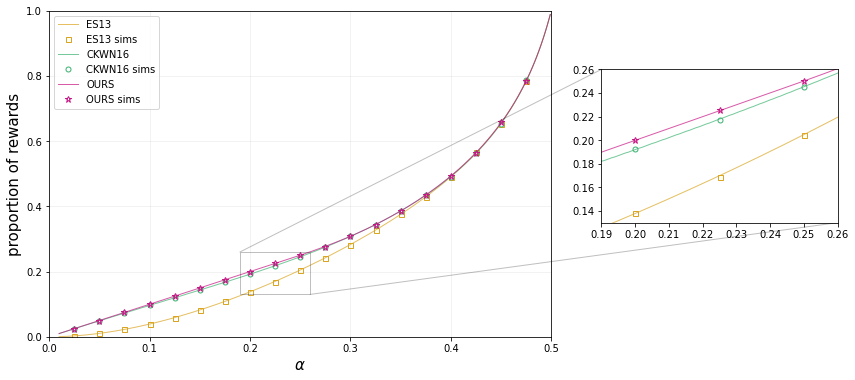

In [24]:
f, ax = plt.subplots(figsize=(9,6))

axins = ax.inset_axes(
    [1.1, 0.35, 0.47, 0.47],
    xlim=(.19, .26), ylim=(.13, .26))

ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)


for a in [ax, axins]:
    a.plot(alphas, ES_tho_beta_infty, linewidth=1, color='goldenrod', alpha=0.7, label='ES13', 
            linestyle='-')
    a.plot(simAlphas, ES_sim_lambda, color='goldenrod', alpha=1, label='ES13 sims', marker='s', 
           fillstyle='none', linestyle='none', markersize=5)
        
    a.plot(alphas, CKWN_theo_opt_beta, linewidth=1, color='mediumseagreen', alpha=0.7, label='CKWN16', 
            linestyle='-')
    a.plot(simAlphas, CKWN_sim_lambda, color='mediumseagreen', alpha=1, label='CKWN16 sims', marker='o', 
           fillstyle='none', linestyle='none', markersize=5)

    a.plot(alphas, OURS_theo_opt_beta, linewidth=1, color='mediumvioletred', alpha=0.7, label='OURS', 
            linestyle='-')
    a.plot(simAlphas, OURS_sim_lambda, color='mediumvioletred', alpha=1, label='OURS sims', marker='*', 
           fillstyle='none', linestyle='none', markersize=7)
    
    
#     a.plot(alphas,alphas, color='k', alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)

plt.savefig('out.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

# 3 gammas:

In [44]:
# CKWN optimal betas (exec rewards only)
alphas = np.arange(0.01, 0.5, 0.001)
betas  = np.arange(0.01, 5.01, 0.01)
gammas = [0., 0.25, .5]

opt_betas_exec = []
for gamma in gammas:
    temp = []
    for alpha in tqdm(alphas):
        rews = [REWARD2(alpha=alpha, beta=b, gamma=gamma) for b in betas]
        temp.append(betas[np.argmax(rews)])
    opt_betas_exec.append(temp)
opt_betas_exec = np.asarray(opt_betas_exec)
opt_betas_exec.shape

100%|██████████| 490/490 [00:03<00:00, 140.52it/s]


(3, 490)

In [45]:
# our optimal betas (exec & block rewards only)
alphas = np.arange(0.01, 0.5, 0.001)
betas  = np.arange(0.01, 10.01, 0.01)
opt_betas_both = []
for gamma in gammas:
    temp = []
    for alpha in tqdm(alphas):
        rews = [calcTotalRewardGamma(a=alpha, b=b, gamma=gamma, scale=1.) for b in betas]
        temp.append(betas[np.argmax(rews)])
    opt_betas_both.append(temp)
opt_betas_both = np.asarray(opt_betas_both)

100%|██████████| 490/490 [00:15<00:00, 30.78it/s]


In [49]:
CKWN_theo_opt_beta = []
OURS_theo_opt_beta = []
ES_tho_beta_infty  = []
for j, gamma in enumerate(gammas):
    temp1, temp2, temp3 = [], [], []
    for i in tqdm(range(len(alphas))):
        a, optb_exec, optb_both = alphas[i], opt_betas_exec[j,i], opt_betas_both[j,i]
        temp1.append(calcTotalRewardGamma(a=a, b=optb_exec, gamma=gamma, scale=1.))
        temp2.append(calcTotalRewardGamma(a=a, b=optb_both, gamma=gamma, scale=1.))
        temp3.append(calcTotalRewardGamma(a=a, b=100., gamma=gamma, scale=1.))
    CKWN_theo_opt_beta.append(temp1)
    OURS_theo_opt_beta.append(temp2)
    ES_tho_beta_infty.append(temp3)
CKWN_theo_opt_beta = np.array(CKWN_theo_opt_beta)
OURS_theo_opt_beta = np.array(OURS_theo_opt_beta)
ES_tho_beta_infty  = np.array(ES_tho_beta_infty)
CKWN_theo_opt_beta.shape, OURS_theo_opt_beta.shape, ES_tho_beta_infty.shape 

100%|██████████| 490/490 [00:00<00:00, 10359.02it/s]


((3, 490), (3, 490), (3, 490))

In [62]:
gammas

[0.0, 0.25, 0.5]

In [65]:
simAlphas = np.arange(0.025, 0.5, 0.025)
CKWN_sim_lambda = []
for gamma in gammas:
    temp2 = []
    for a in simAlphas:
        optb = findOptBetaExec(a, gamma)
        print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
        temp = []
        for j in range(10):
            temp.append(simCKWN_beta_lambda(alpha=a, gamma=gamma, beta=optb, scale=1., n=int(1e5)))
        temp2.append(np.mean(temp))
    CKWN_sim_lambda.append(temp2)
CKWN_sim_lambda = np.array(CKWN_sim_lambda)
CKWN_sim_lambda.shape

(3, 19)

In [66]:
simAlphas = np.arange(0.025, 0.5, 0.025)
OURS_sim_lambda = []
for gamma in gammas:
    temp2 = []
    for a in simAlphas:
        optb = findOptBetaBoth(a, gamma)
        print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
        temp = []
        for j in range(10):
            temp.append(simCKWN_beta_lambda(alpha=a, gamma=gamma, beta=optb, scale=1., n=int(1e5)))
        temp2.append(np.mean(temp))
    OURS_sim_lambda.append(temp2)
OURS_sim_lambda = np.array(OURS_sim_lambda)
OURS_sim_lambda.shape

(3, 19)

In [92]:
simAlphas = np.arange(0.025, 0.5, 0.025)
ES_sim_lambda = []
for gamma in gammas:
    temp2 = []
    for a in simAlphas:
        optb = 100.
        print('alpha={:0.3f}'.format(a), end='\r')
        temp = []
        for j in range(10):
            temp.append(simCKWN_beta_lambda(alpha=a, gamma=gamma, beta=optb, scale=1., n=int(1e5)))
        temp2.append(np.mean(temp))
    ES_sim_lambda.append(temp2)
ES_sim_lambda = np.array(ES_sim_lambda)
ES_sim_lambda.shape

(3, 19)

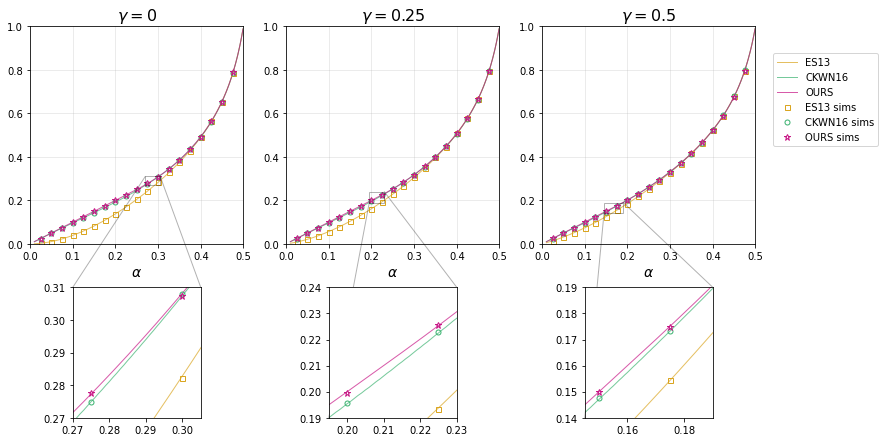

In [94]:
f, axarr = plt.subplots(ncols=3, figsize=(13,4))

axins0 = axarr[0].inset_axes(
    [0.2, -0.8, 0.6, 0.6],
    xlim=(.27, .305), ylim=(.27, .31))
axarr[0].indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)

axins1 = axarr[1].inset_axes(
    [0.2, -0.8, 0.6, 0.6],
    xlim=(.195, .23), ylim=(.19, .24))
axarr[1].indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)

axins2 = axarr[2].inset_axes(
    [0.2, -0.8, 0.6, 0.6],
    xlim=(.145, .19), ylim=(.14, .19))
axarr[2].indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)

axins = [axins0, axins1, axins2]

for i in range(3):
    for ax in [axarr[i], axins[i]]:
        ax.plot(alphas, ES_tho_beta_infty[i], linewidth=1, color='goldenrod', alpha=0.7, label='ES13', 
                linestyle='-')
        ax.plot(alphas, CKWN_theo_opt_beta[i], linewidth=1, color='mediumseagreen', alpha=0.7, label='CKWN16', 
                linestyle='-')
        ax.plot(alphas, OURS_theo_opt_beta[i], linewidth=1, color='mediumvioletred', alpha=0.7, label='OURS', 
                linestyle='-')
        
        ax.plot(simAlphas, ES_sim_lambda[i], color='goldenrod', alpha=1, label='ES13 sims', marker='s', 
               fillstyle='none', linestyle='none', markersize=5)
        ax.plot(simAlphas, CKWN_sim_lambda[i], color='mediumseagreen', alpha=1, label='CKWN16 sims', marker='o', 
               fillstyle='none', linestyle='none', markersize=5)
        ax.plot(simAlphas, OURS_sim_lambda[i], color='mediumvioletred', alpha=1, label='OURS sims', marker='*', 
               fillstyle='none', linestyle='none', markersize=7)

for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,1)
    ax.set_xlabel(r'$\alpha$', size=14)

axarr[2].legend(bbox_to_anchor=(1.6, 0.9))

axarr[0].set_title(r'$\gamma=0$', size=16)
axarr[1].set_title(r'$\gamma=0.25$', size=16)
axarr[2].set_title(r'$\gamma=0.5$', size=16)


# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()